In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KernelDensity
import seaborn as sns

In [2]:
def calc_log_lr_cost(data, score_col): 

    if score_col == "count_lr":
        lr_same = np.exp(data[score_col][data['same_source']])
        lr_diff = np.exp(data[score_col][data['same_source']])
    else:
        lr_same = data[score_col][data['same_source']]
        lr_diff = data[score_col][~data['same_source']]
        
    return 0.5 * np.mean(np.log2(1 + 1/(lr_same))) + \
           0.5 * np.mean(np.log2(1 + lr_diff))

In [3]:
def get_metrics_for_dataset(dataset, n_rep):
    test_files = ['./results2/' + dataset + '_test' + str(i) + '.csv' for i in range(n_rep)]

    # store results
    results_df_list = []

    methods = [
        "luar_avg_lr",
        "luar_tru_lr",
        "luar_win_lr",
        "cisr_tru_lr",
        "cisr_avg_lr",
        "znorm_lr",
        "lex_lr",
        "count_lr" # this is on ln scale; doesn't matter for auc, adjusted for cllr
    ]

    for j in range(n_rep):
        lr_results = pd.read_csv(test_files[j])

        results_df_list.append(
            pd.DataFrame(
                {
                    "Method": methods,
                    "Run": [j]*len(methods),
                    "Category": ["embedding"]*5+["manual"]*3,
                    "AUC": [roc_auc_score(lr_results.same_source, lr_results[m].tolist()) for m in methods],
                    "Cllr": [calc_log_lr_cost(lr_results, m) for m in methods]
                }
            )
        )

    return pd.concat(results_df_list)

In [4]:
sns.set(style='whitegrid')

In [ ]:
def plot_auc_boxplot_points(ax, data, title, avg=False):
    if avg:
        plot_data = data.loc[data["Method"].isin(['luar_avg_lr', 'cisr_avg_lr', 'znorm_lr', 'lex_lr', 'count_lr']), :]
    else:
        plot_data = data.loc[data["Method"].isin(['luar_tru_lr', 'cisr_tru_lr', 'znorm_lr', 'lex_lr', 'count_lr']), :]

    sns.boxplot(data=plot_data, x="Method", y="AUC", hue="Category", ax=ax, boxprops={"alpha": 0.5})
    sns.stripplot(data=plot_data, x="Method", y="AUC", hue="Category", ax=ax)
    ax.set_ylim(0.5, 1)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(["LUAR", "CISR", "BoW", "Lexical", "Multinomial"])
    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
            labels=["embedding", "manual"],
            loc='upper right', handlelength=4,
            handler_map={tuple: matplotlib.legend_handler.HandlerTuple(ndivide=None)})


In [6]:
dr = get_metrics_for_dataset("darkreddit", 15)
sr = get_metrics_for_dataset("silkroad", 15)
ag = get_metrics_for_dataset("agora", 15)
am = get_metrics_for_dataset("amazon", 15)

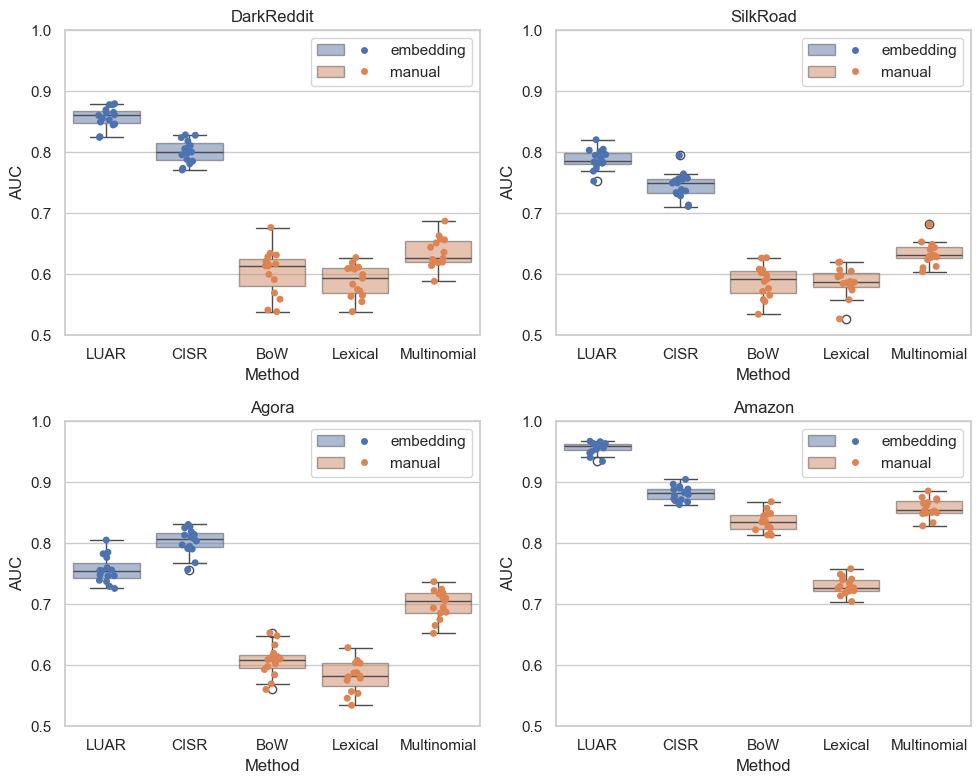

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plot_auc_boxplot_points(ax[0,0], dr, "DarkReddit")
plot_auc_boxplot_points(ax[0,1], sr, "SilkRoad")
plot_auc_boxplot_points(ax[1,0], ag, "Agora")
plot_auc_boxplot_points(ax[1,1], am, "Amazon", avg=True)
plt.tight_layout()
plt.show()

In [11]:
def create_cllr_table(datasets):
    summary_df_list = []
    for dataset in datasets:
        df = get_metrics_for_dataset(dataset, 15)
        cllr_summary = df.groupby('Method').agg({'Cllr': ['min', 'max', 'mean']}).loc[:, "Cllr"].reset_index()
        cllr_summary["table_val"] = cllr_summary.round(2).loc[:, "mean"].astype(str) + " (" + cllr_summary.round(2).loc[:, "min"].astype(str) + ", " + cllr_summary.round(2).loc[:, "max"].astype(str) + ")"
        cllr_summary["dataset"] = dataset
        summary_df_list.append(cllr_summary)

    return pd.concat(summary_df_list)

In [13]:
create_cllr_table(["darkreddit", "agora", "silkroad", "amazon"]).pivot(index="Method", columns="dataset", values="table_val")

dataset,agora,amazon,darkreddit,silkroad
Method,,,,
cisr_avg_lr,"0.8 (0.76, 0.86)","inf (0.56, inf)","0.78 (0.74, 0.83)","0.86 (0.8, 0.91)"
cisr_tru_lr,"0.78 (0.75, 0.85)","0.77 (0.68, 1.02)","0.79 (0.75, 0.83)","0.86 (0.81, 0.91)"
count_lr,"2.72 (2.32, 3.5)","9.7 (8.66, 10.75)","7.84 (4.13, 9.54)","2.48 (2.14, 2.67)"
lex_lr,"0.98 (0.96, 1.0)","0.88 (0.85, 0.91)","0.97 (0.96, 1.0)","0.98 (0.97, 1.0)"
luar_avg_lr,"0.86 (0.79, 0.89)","0.39 (0.34, 0.46)","0.68 (0.63, 0.74)","0.8 (0.75, 0.86)"
luar_tru_lr,"0.85 (0.78, 0.89)","0.5 (0.46, 0.56)","0.68 (0.63, 0.74)","0.8 (0.75, 0.85)"
luar_win_lr,"0.84 (0.78, 0.89)","0.59 (0.54, 0.65)","0.76 (0.7, 0.82)","0.86 (0.8, 0.96)"
znorm_lr,"0.98 (0.94, 1.01)","0.73 (0.67, 0.79)","0.97 (0.92, 1.06)","0.99 (0.97, 1.05)"


In [13]:
am = get_metrics_for_dataset("Amazon", 15)
am.loc[am["Method"] == "cisr_avg_lr", :]

,Method,Run,Category,AUC,Cllr
4,cisr_avg_lr,0,embedding,0.888960,0.625138
4,cisr_avg_lr,1,embedding,0.896928,0.575019
4,cisr_avg_lr,2,embedding,0.888416,0.612994
4,cisr_avg_lr,3,embedding,0.867744,0.708981
4,cisr_avg_lr,4,embedding,0.871392,0.735425
4,cisr_avg_lr,5,embedding,0.882944,0.781404
4,cisr_avg_lr,6,embedding,0.893152,0.606964
4,cisr_avg_lr,7,embedding,0.886288,0.673168
4,cisr_avg_lr,8,embedding,0.904752,0.561873
4,cisr_avg_lr,9,embedding,0.872640,1.141489


In [14]:
test_files = ['./results2/' + "amazon" + '_test' + str(i) + '.csv' for i in range(15)]
lr_results = pd.read_csv(test_files[13])

In [15]:
lr_results.loc[lr_results["cisr_avg_lr"] == 0, :]

,problem_id,same_source,luar_avg_lr,luar_tru_lr,luar_win_lr,cisr_avg_lr,cisr_tru_lr,znorm_lr,lex_lr,count_lr
222,5747,True,2.946486e-01,8.628004e-02,1.044835e+00,0.0,6.797929e-40,1.916699,0.935788,-46.623517
275,6894,False,3.717036e-02,9.422009e-02,4.381702e-02,0.0,3.314055e-119,0.114056,0.958963,-60.974111
282,7120,False,5.469727e-02,2.520823e-01,2.369152e-02,0.0,1.064007e-39,0.208933,0.354426,-41.212902
317,7772,False,2.658684e-03,4.705987e-02,2.173040e-02,0.0,3.580685e-56,0.221970,0.309873,-35.773111
372,9676,False,1.124622e-02,4.774333e-02,2.040704e-02,0.0,4.044275e-18,0.075585,0.190206,-74.063261
373,9693,False,2.036864e-14,1.120378e-05,4.216391e-37,0.0,7.486737e-48,0.607200,0.198888,-53.775449
431,11066,False,7.071945e-39,2.565465e-14,6.939199e-03,0.0,5.195876e-45,2.249947,0.966884,-35.114847


In [16]:
lr_results = pd.read_csv(test_files[12])

In [17]:
text0 = "For clarification s sake, I m not what I d call a tech junkie. Others in my family think of me as such (I spend an awful lot of my workday on the PC, and I routinely make use of smartphones, tablets, and other assorted gadgets and gizmos). But if you re looking for some type of quantitative analysis of Product A versus Product B, then the best I can do is compare for you as a consumer what works best about one choice over the other. I can t give you any kind of substantive breakdown on the technology used in assembling them. Heck, in some instances, I can t even quite tell you how they work! What I can tell you is that, as a consumer, I know what I like, and I m very vocal about those things I do.With that qualifier out of the way, let me tell you first and foremost why I ve personally had to make use of products like AXO s 2600mAh External battery. One of the places where I go for periodic work tends to be in what I d call a wireless desert: I get terrible reception, and my iPhone is constantly roaming to try to pick up local signal. As such, the battery gets fairly low after about six-to-eight hours, not to the point of having the thing shut down completely but because I m the kind of person who gets uptight about it then I prefer having a battery on-hand with which to juice back up. Call me obsessive-compulsive about it, but that s my cross to bear.Consequently, this is precisely the kind of product small, convenient, and reliable that I like to turn to when that happens (which is about twice a week). Granted, there are always other options when I m in a workplace access to a PC to get a power boost, or even carrying along an AC charge cord (which I occasionally do) but I prefer the independence of protecting my data from accidentally being collected on someone else s hard-drive so the AXO product is designed with folks like me in mind. It s small enough to be carried on my person.Charge time states in the manual of six hours, and mine took a bit longer (about six-and-one-half) to show full charge. No big deal so far as I m concerned.Positives:First, unlike other manufactured batteries I ve tested/reviewed, the OXA model is designed for greater flexibility as the provided USB cable can be used with different provided connectors. The four connectors include heads that can be used with the most popular iPhones but also appeared to be compatible with some tablets. (As I m no expert on these matters, I can t say which specifically.)Second, the OXA model is designed with a convenient key-attachment for those of you who d rather keep it available within arm s reach at a moment s notice. Because this is an electronics gadget and as such probably has some internal components that don t need the extra jostling about or banging up against my heavy car keys, I probably won t use it as such BUT I ve already encouraged my wife to keep her few work keys on it and carry it in her briefcase. It s the perfect size and shape for that.Third, (again) unlike some other manufactured batteries I ve tested/reviewed, the OXA model comes complete with an actual user s manual. (I can t tell you how sadly rare this is.) Info junkies such as myself crave those days of old when suppliers were actually obligated to give us some details not just a few lines of description on the product packaging or refer us to some website wherein we can review posted information about what we re using. Granted, it s short and sweet BUT it s perfectly sized to fit in the small plastic bag containing the aforementioned connectors. MAJOR kudos, AXO!Lastly, the model has a little red indicator light built directly under the opaque housing. The light glows red while it s charging, and it turns off when the unit is fully prepped. It s that simple."
text1 = "In the late 80's and early 90's, Justin Duerr became fascinated with these tiles he uncovered in the Philadelphia streets. There were all largely similar in that they featured some basic prose: \"Toynbee idea ... in Kubrick's 2001 ... Resurrect Dead ... on Planet Jupiter.\" Occasionally, the tiles would offer some kind of post-script or sidebar that detailed a larger narrative - thought to be about the life of the tile's author - but the central message about resurrecting the dead was always the same. As Duerr's interest grew, so did his sightings of the Toynbee tiles. A budding artist himself, Duerr is drawn into unlocking the mystery behind the tiles' author and creator - attempting to understand the intents and motivations behind this secret `viral' campaign at a time long before the internet put its stamp on our culture.Such is the case of RESURRECT DEAD: THE MYSTERY OF THE TOYNBEE TILES. As Duerr takes us on a personal journey, he slowly comes to the realization that `personal journeys' are precisely what life is all about. Sightings of the tiles grow from city to city (and ultimately even to other countries), driving him into a near obsession to understand what it may all mean. Is it a message? Is it a cryptic warning? Is it a reflection on life? Could it be a hint of things to come? At the center of it all (as is the case with all good puzzles) is the classic `whodunit'; clearly someone - or some group - is behind it all, and the fun comes in trying to unravel that grand identity.That's where RESURRECT DEAD excels; it postulates several identities - based on the few established facts - and then begins to dissect it all for the viewer. The audience is brought along - step by step - into the act of solving the mystery, and it's a pleasant enough ride. It's an inventive puzzle - one that involves radical street art, reclusive geniuses, and even internet nerds. What it shows uniquely is that there's always a human element at the heart of any good mystery - a face to the enigma - and, whether that human is flawed or perfect, he's still inevitably misunderstood - despite the best efforts of even the world's greatest detectives. It's a curiously amazing little documentary that shows how one man - working solely from his own message and inspiration - can try to change the world.The disc has been produced by Focus World. Visually, it's smartly constructed, though the editing of transitions seems to be a little sloppy for my tastes; fades seem to hold a bit long on the screen, and the picture could've easily be trimmed a few minutes with some elementary cuts and trims. Still, it looks good. Special features include an audio commentary by the film's director and the three novice investigators featured in the production. There's also a compilation of many of the Toynbee tiles captured in a stills gallery, some additional footage (nothing special), and deleted scenes.STRONGLY RECOMMENDED for fans of documentaries and even fans of mysteries. RESURRECT DEAD is essentially a procedural trying to uncover the secrets at the heart of a very human mystery. While it may not be to everyone's liking, it certainly pulls back the layers - one-at-a-time - until the viewers left with what may seem like an all-too-perfect, movie-style conclusion that begs credulity just a bit but no less satisfying.In the interests of fairness, I'm pleased to disclose that the fine folks at Entertainment One provided me with a DVD screener for the expressed purposes of completing this review. For years, the infamous `what if?' scenario has played into the themes central to hundreds if not thousands of films, books, and television programs. Indeed, what would ABC TV's program \"Lost\" been without more than its fair share of `what ifs'? It's become a bit of a gimmick for motion pictures in the last decade or so, perhaps a bit overused, but BLACKTHORN takes a swing at it and gives it another play for its worth: what if Butch Cassidy never died at the end of BUTCH CASSIDY "

In [18]:
from transformers import AutoModel, AutoTokenizer
import torch
from more_itertools import windowed
from scipy.spatial import distance

/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
tokenizer = AutoTokenizer.from_pretrained('AnnaWegmann/Style-Embedding')
model = AutoModel.from_pretrained('AnnaWegmann/Style-Embedding')

/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [61]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [62]:
def cisr_tokenize(text):
    tokenized = tokenizer(text, max_length=512, padding="do_not_pad", truncation="do_not_truncate", return_tensors="np")
    token_ids = tokenized['input_ids']
    token_mask = tokenized['attention_mask']
    # remove the start/end tokens (which are 0 and 2)
    text_tokens = token_ids[0][1:(len(token_ids[0])-1)]
    text_mask = token_mask[0][1:(len(token_mask[0])-1)]
    # get the chunks of length 510
    token_chunks = list(windowed(text_tokens, n=510, step=510-32))
    mask_chunks = list(windowed(text_mask, n=510, step=510-32))
    embeddings = []
    for i in range(len(token_chunks)):
        tokens = list(token_chunks[i])
        tokens = [t for t in tokens if t is not None]
        tokens.insert(0,0)
        tokens.append(2)
        mask = list(mask_chunks[i])
        mask = [m for m in mask if m is not None]
        mask.insert(0, 1)
        mask.append(1)

        tokens = torch.tensor(tokens).reshape(1, -1)
        mask = torch.tensor(mask).reshape(1, -1)

        tokenized_chunk = {'input_ids': tokens, 'attention_mask': mask}

        with torch.no_grad():
            model_output = model(**tokenized_chunk)
        
        embeddings.append(mean_pooling(model_output, tokenized_chunk['attention_mask']).detach().numpy()[0,])

    return np.mean(embeddings, axis = 0)

In [64]:
distance.cosine(cisr_tokenize(text0), cisr_tokenize(text1))

1.2299988567829132

In [65]:
from pprint import pprint

In [69]:
pprint(text0)

('For clarification s sake, I m not what I d call a tech junkie. Others in my '
 'family think of me as such (I spend an awful lot of my workday on the PC, '
 'and I routinely make use of smartphones, tablets, and other assorted gadgets '
 'and gizmos). But if you re looking for some type of quantitative analysis of '
 'Product A versus Product B, then the best I can do is compare for you as a '
 'consumer what works best about one choice over the other. I can t give you '
 'any kind of substantive breakdown on the technology used in assembling them. '
 'Heck, in some instances, I can t even quite tell you how they work! What I '
 'can tell you is that, as a consumer, I know what I like, and I m very vocal '
 'about those things I do.With that qualifier out of the way, let me tell you '
 'first and foremost why I ve personally had to make use of products like AXO '
 's 2600mAh External battery. One of the places where I go for periodic work '
 'tends to be in what I d call a wireless d

In [70]:
pprint(text1)

("In the late 80's and early 90's, Justin Duerr became fascinated with these "
 'tiles he uncovered in the Philadelphia streets. There were all largely '
 'similar in that they featured some basic prose: "Toynbee idea ... in '
 'Kubrick\'s 2001 ... Resurrect Dead ... on Planet Jupiter." Occasionally, the '
 'tiles would offer some kind of post-script or sidebar that detailed a larger '
 "narrative - thought to be about the life of the tile's author - but the "
 "central message about resurrecting the dead was always the same. As Duerr's "
 'interest grew, so did his sightings of the Toynbee tiles. A budding artist '
 "himself, Duerr is drawn into unlocking the mystery behind the tiles' author "
 'and creator - attempting to understand the intents and motivations behind '
 "this secret `viral' campaign at a time long before the internet put its "
 'stamp on our culture.Such is the case of RESURRECT DEAD: THE MYSTERY OF THE '
 'TOYNBEE TILES. As Duerr takes us on a personal journey, he s

In [74]:
am_train_scores = pd.read_csv('./results2/amazon_train' + str(13) + '.csv')
am_train_scores

,problem_id,same_source,luar_avg_score,luar_tru_score,luar_win_score,cisr_avg_score,cisr_tru_score,znorm_score,lex_score
0,0,True,0.165390,0.223350,0.122144,0.149820,0.275126,0.849218,0.504809
1,6,True,0.170542,0.241477,0.101737,0.069750,0.303436,0.921922,0.801491
2,48,True,0.226301,0.264323,0.100634,0.027144,0.035019,0.915715,0.742539
3,75,True,0.132566,0.171119,0.058844,0.028319,0.068931,0.972715,0.191138
4,132,True,0.144066,0.176226,0.069765,0.039751,0.017964,0.984962,0.632318
...,...,...,...,...,...,...,...,...,...
1995,119103,False,0.424723,0.507636,0.137597,0.339527,0.413659,0.971201,1.677783
1996,119104,False,0.264546,0.360354,0.119778,0.804936,0.683718,1.013362,0.985310
1997,119126,False,0.230356,0.211807,0.126977,0.810146,0.907058,1.014213,0.274967
1998,119157,False,0.305718,0.369373,0.160196,0.166858,0.224926,0.974190,0.610796


In [75]:
ss_scores = am_train_scores.cisr_avg_score[am_train_scores.same_source]
ds_scores = am_train_scores.cisr_avg_score[~am_train_scores.same_source]

In [76]:
n = len(ss_scores)
iqr_ss = np.quantile(ss_scores, 0.75) - np.quantile(ss_scores, 0.25)
b_ss = min(np.std(ss_scores), iqr_ss/1.34)
iqr_ds = np.quantile(ds_scores, 0.75) - np.quantile(ds_scores, 0.25)
b_ds = min(np.std(ds_scores), iqr_ds/1.34)
ss_bw = 0.9*b_ss*n**(-1/5)
ds_bw = 0.9*b_ds*n**(-1/5)

ss_kde = KernelDensity(kernel="gaussian", bandwidth=ss_bw).fit(np.array(ss_scores)[:, np.newaxis])
ds_kde = KernelDensity(kernel="gaussian", bandwidth=ds_bw).fit(np.array(ds_scores)[:, np.newaxis])

In [85]:
ss_kde.score_samples(np.array([distance.cosine(cisr_tokenize(text0), cisr_tokenize(text1))])[:, np.newaxis])

array([-1698.09040892])

In [86]:
ds_kde.score_samples(np.array([distance.cosine(cisr_tokenize(text0), cisr_tokenize(text1))])[:, np.newaxis])

array([-2.36405493])

In [53]:
lr_results.loc[lr_results["cisr_avg_lr"] == 0, :]

,problem_id,same_source,luar_avg_lr,luar_tru_lr,luar_win_lr,cisr_avg_lr,cisr_tru_lr,znorm_lr,lex_lr,count_lr
230,5746,True,2.624630e+00,1.083428,1.256360e+00,0.0,1.034529e-01,0.439023,0.463967,-34.918420
265,6649,False,1.241433e-12,0.020253,8.036041e-82,0.0,5.060097e-89,0.104693,0.221938,-49.199378
320,8075,False,9.321484e-06,0.034649,1.121459e-24,0.0,7.655201e-74,2.362188,0.564266,-16.603782
415,10368,False,8.107056e-11,0.018382,7.851961e-18,0.0,3.235355e-55,0.091020,0.817047,-60.155572
426,10734,False,2.681790e-02,0.036965,2.651442e-02,0.0,8.907496e-23,0.704216,1.523772,-40.778446


In [25]:
create_cllr_table(["DarkReddit", "Agora", "Amazon"]).pivot(index="Method", columns="dataset", values="table_val").reset_index()

dataset,Method,Agora,Amazon,DarkReddit
0,cisr_avg_lr,"0.8 (0.76, 0.86)","inf (0.56, inf)","0.78 (0.74, 0.83)"
1,cisr_tru_lr,"0.78 (0.75, 0.85)","0.77 (0.68, 1.02)","0.79 (0.75, 0.83)"
2,count_lr,"2.72 (2.32, 3.5)","9.7 (8.66, 10.75)","7.84 (4.13, 9.54)"
3,lex_lr,"0.98 (0.96, 1.0)","0.88 (0.85, 0.91)","0.97 (0.96, 1.0)"
4,luar_avg_lr,"0.86 (0.79, 0.89)","0.39 (0.34, 0.46)","0.68 (0.63, 0.74)"
5,luar_tru_lr,"0.85 (0.78, 0.89)","0.5 (0.46, 0.56)","0.68 (0.63, 0.74)"
6,luar_win_lr,"0.84 (0.78, 0.89)","0.59 (0.54, 0.65)","0.76 (0.7, 0.82)"
7,znorm_lr,"0.98 (0.94, 1.01)","0.73 (0.67, 0.79)","0.97 (0.92, 1.06)"


In [122]:
am.loc[am["Method"] == "cisr_avg_lr",:]

,Method,Run,Category,AUC,Cllr
4,cisr_avg_lr,0,embedding,0.888960,0.625138
4,cisr_avg_lr,1,embedding,0.896928,0.575019
4,cisr_avg_lr,2,embedding,0.888416,0.612994
4,cisr_avg_lr,3,embedding,0.867744,0.708981
4,cisr_avg_lr,4,embedding,0.871392,0.735425
4,cisr_avg_lr,5,embedding,0.882944,0.781404
4,cisr_avg_lr,6,embedding,0.893152,0.606964
4,cisr_avg_lr,7,embedding,0.886288,0.673168
4,cisr_avg_lr,8,embedding,0.904752,0.561873
4,cisr_avg_lr,9,embedding,0.872640,1.141489


In [78]:
cllr_summary = dr_plot.groupby('Method').agg({'Cllr': ['min', 'max', 'mean']}).loc[:, "Cllr"].reset_index()

In [79]:
cllr_summary.round(2)

,Method,min,max,mean
0,cisr_tru_lr,0.75,0.83,0.79
1,count_lr,4.13,9.54,7.84
2,lex_lr,0.96,1.00,0.97
3,luar_tru_lr,0.63,0.74,0.68
4,znorm_lr,0.92,1.06,0.97


In [86]:
cllr_summary["table_val"] = cllr_summary.round(2).loc[:, "mean"].astype(str) + " (" + cllr_summary.round(2).loc[:, "min"].astype(str) + ", " + cllr_summary.round(2).loc[:, "max"].astype(str) + ")"

In [87]:
cllr_summary

,Method,min,max,mean,table_val
0,cisr_tru_lr,0.746830,0.827000,0.786944,"0.79 (0.75, 0.83)"
1,count_lr,4.133087,9.539484,7.835878,"7.84 (4.13, 9.54)"
2,lex_lr,0.956961,1.000963,0.974587,"0.97 (0.96, 1.0)"
3,luar_tru_lr,0.631005,0.741802,0.682441,"0.68 (0.63, 0.74)"
4,znorm_lr,0.920970,1.064335,0.973499,"0.97 (0.92, 1.06)"


In [17]:
def plot_tippett_plots(dataset, avg=False, x=2, mn_x=2):
    fig, ax = plt.subplots(3, 2, figsize=(8, 10))
    test_files = ['./results2/' + dataset + '_test' + str(i) + '.csv' for i in range(15)]
    if avg:
        methods = ["luar_avg_lr", "cisr_avg_lr", "znorm_lr", "lex_lr", "count_lr"]
    else:
        methods = ["luar_tru_lr", "cisr_tru_lr", "znorm_lr", "lex_lr", "count_lr"]

    plot_methods = ["LUAR", "CISR", "BoW", "Lexical", "Multinomial"]
    method_rows = [0]*2 + [1]*2 + [2]*2
    method_cols = [0, 1]*3

    for k in range(len(methods)):
        for f in test_files:
            lr_results = pd.read_csv(f)
            if methods[k] == "count_lr": # multinomial on ln scale
                lr_results["log10" + methods[k]] = lr_results.loc[:, [methods[k]]].transform(lambda x: x / np.log(10))
            else:
                lr_results["log10" + methods[k]] = lr_results.loc[:, [methods[k]]].transform(lambda x: np.log(x) / np.log(10))
            sns.ecdfplot(data=lr_results, 
                         x="log10" + methods[k], 
                         hue="same_source", 
                         complementary=True, 
                         linewidth=1.5, 
                         palette={True: "red", False: "blue"}, 
                         alpha=0.3, 
                         ax=ax[method_rows[k], method_cols[k]])
        if methods[k] == "count_lr":
            ax[method_rows[k], method_cols[k]].set_xlim(-mn_x, mn_x)
        else:
            ax[method_rows[k], method_cols[k]].set_xlim(-x, x)
        ax[method_rows[k], method_cols[k]].axvline(0, color='black', linestyle="--", linewidth=2.5)
        ax[method_rows[k], method_cols[k]].set_xlabel("Log10(LR) Greater Than")
        ax[method_rows[k], method_cols[k]].set_title(plot_methods[k])
        ax[method_rows[k], method_cols[k]].legend(["same author", "diff author"], loc="best")

    ax[2, 1].axis("off")
    plt.tight_layout()
    plt.show()

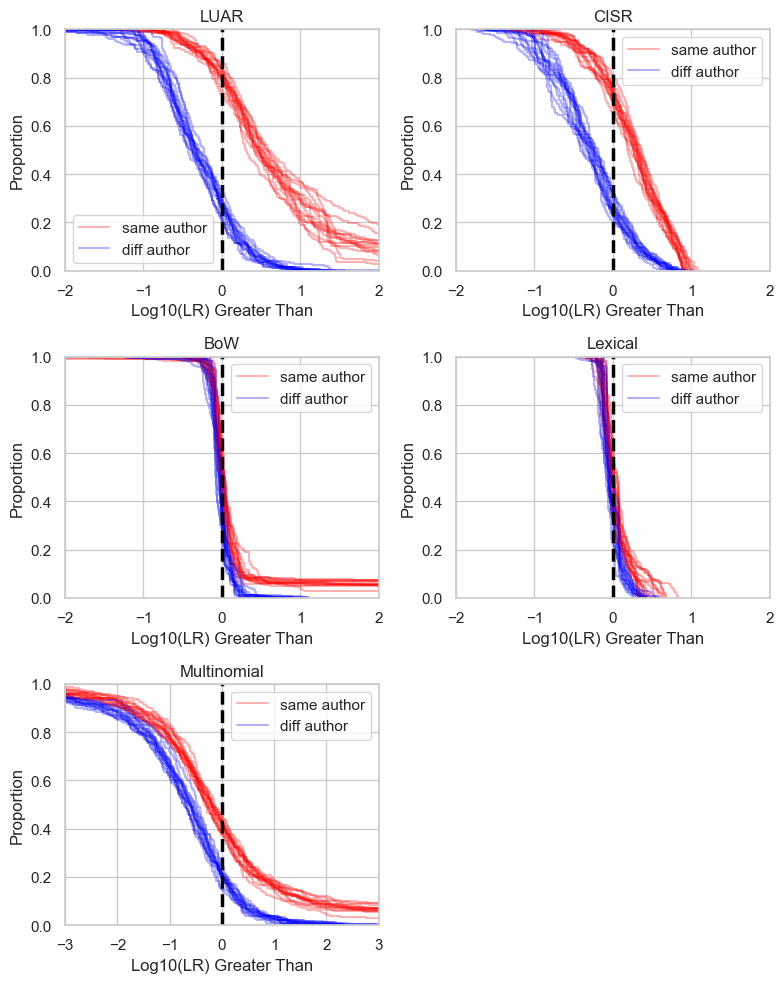

In [15]:
plot_tippett_plots("darkreddit", mn_x=3)

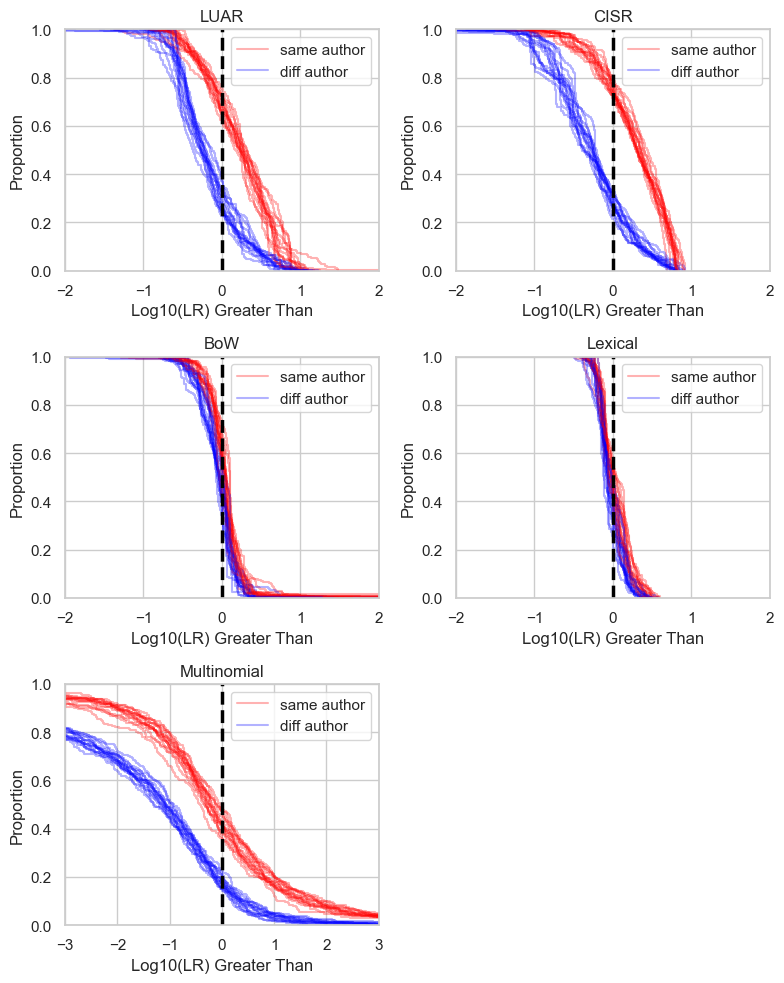

In [16]:
plot_tippett_plots("agora", mn_x=3)

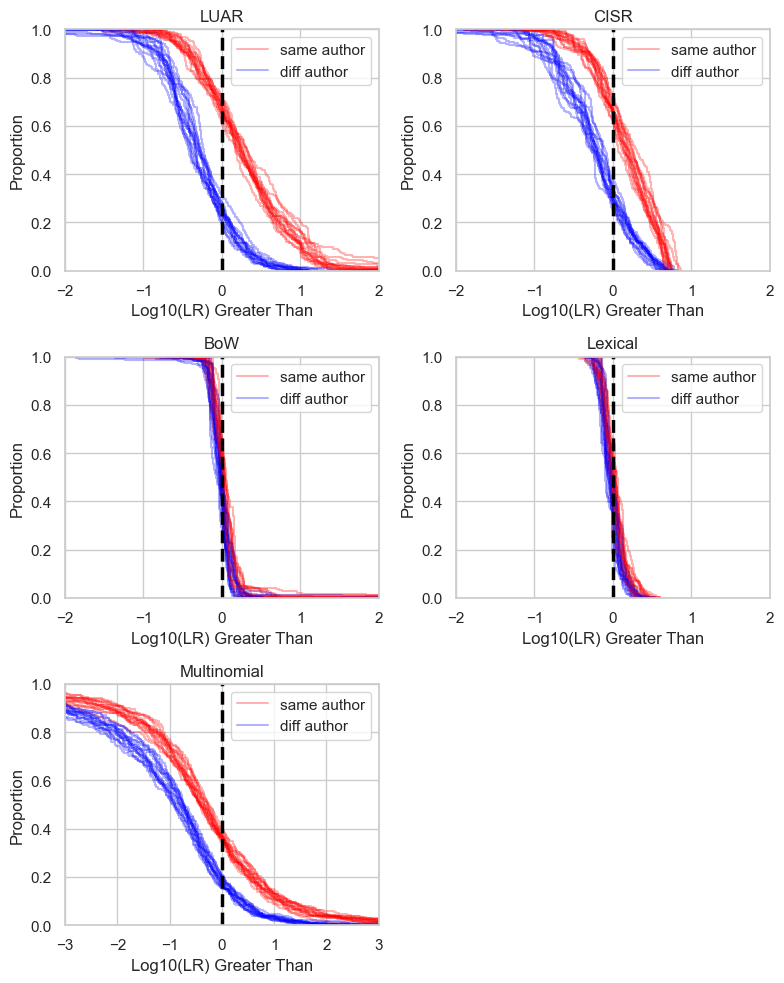

In [18]:
plot_tippett_plots("silkroad", mn_x=3)

/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rachellongjohn/anaconda3/envs/text-forensics/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


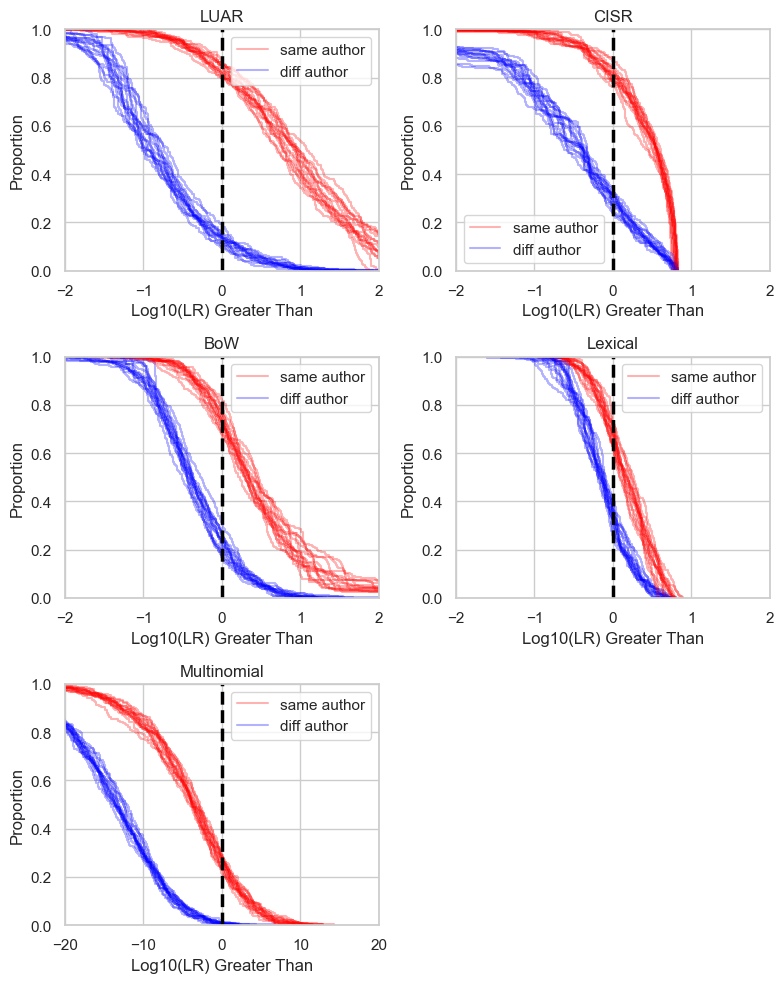

In [24]:
plot_tippett_plots("amazon", mn_x=20)

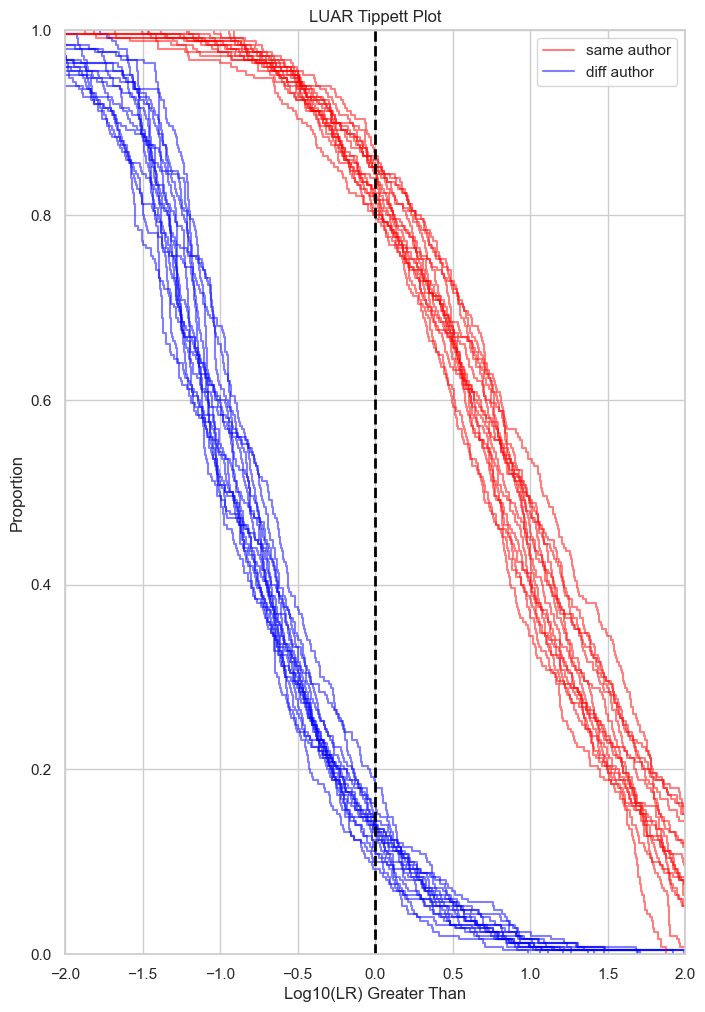

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8, 12))
for f in test_files:
    lr_results = pd.read_csv(f)
    test = lr_results.copy()
    test["log10_luar"] = lr_results.loc[:, ["luar_tru_lr"]].transform(lambda x: np.log(x) / np.log(10))
    sns.ecdfplot(data=test, x="log10_luar", hue="same_source", complementary=True, linewidth=1.5, palette={True: "red", False: "blue"}, alpha=0.5)
ax.set_xlim(-2, 2)
ax.axvline(0, color='black', linestyle="--", linewidth=2)
ax.set_xlabel("Log10(LR) Greater Than")
ax.set_title("LUAR Tippett Plot")
ax.legend(["same author", "diff author"], loc="best")
plt.show()

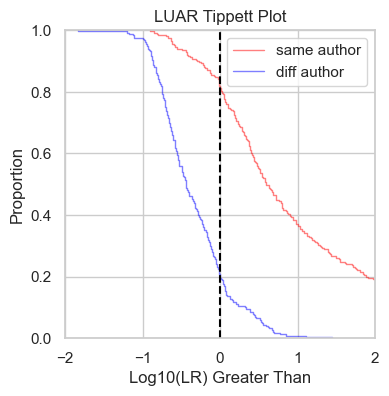

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.ecdfplot(data=test, x="log10_luar", hue="same_source", complementary=True, linewidth=1, palette={True: "red", False: "blue"}, alpha=0.5)
ax.set_xlim(-2, 2)
ax.axvline(0, color='black', linestyle="--", linewidth=1.5)
ax.set_xlabel("Log10(LR) Greater Than")
ax.set_title("LUAR Tippett Plot")
ax.legend(["same author", "diff author"], loc="best")
plt.show()